# Chapter 11. 나이브 베이지안 분류기
## 4. 20newsgroup으로 분류 연습하기
### 01 - 20newsgroup 데이터셋 소개

- 대표적인 텍스트 데이터셋으로 알려진 20newsgroup 데이터셋을 사용하여 20개의 뉴스 텍스트 데이터를 분류하고자 함
    - 20newsgroup 데이터셋 : 처음 인터넷이 등장했을 때 이메일로 소식을 주고받는 'newsgroup'이라는 공간의 데이터를 1990 ~ 2000년대까지 수집해 이 텍스트들이 어떤 주제돠 관련되었는지 보여줌
    - 텍스트 분류 작업을 시작할 때 가장 먼저 다루는 입문용 데이터셋
    - 20newsgroup 데이터셋은 사이킷런에 의해 제공되어 쉽게 접근 가능

- 20newsgroup과 나이브 베이지안 분류기를 사용하여 텍스트 데이터 분류 예시를 제시하고자 함

### 02 - 20newsgroup 데이터셋 불러오기

- 먼저 모듈 호출

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

- 모듈의 호출이 완료되면 20newsgroup 데이터셋을 다운로드
    - 다운로드한 데이터셋은 딕셔너리 타입으로 제공
    - dict의 각 키 값을 통해 데이터에 접근 가능

In [54]:
from sklearn.datasets import fetch_20newsgroups
news = fetch_20newsgroups(subset = 'all')
news.keys()
# data : 실제 데이터
# filenames : 다운로드된 데이터의 파일 위치
# target_names : 데이터 y값의 이름
# target : 데이터 y값의 인덱스
# DESCR : 데이터에 대한 설명

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

- 데이터를 출력해보면 아래 코드와 같음

- 데이터는 매우 간단함
    - 뉴스그룹 데이터 자체가 일종의 메일 형태로 전송됨
        - 우리가 이메일 보내듯이 '보내는 사람', '제목', '내용'으로 구성됨
    - 다음 글에서 상단은 메일의 발송과 관련된 메타데이터, 하단은 메일의 내용

In [55]:
print(news.data[0])

From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!




- y 값에 해당하는 **target, target_names**를 출력하면 아래와 같음
    - y 값의 리스트는 **target_names**에 정의되어 있음
    - 각 메일의 y 값과의 매칭은 **data**와 같은 순서로 **target** 항목에 매칭되어 있음
        - 즉 아래 데이터에서 0번째 **data**의 메일 주제는 인덱스가 10번째 값인 '[rec.sport.hochey]'

In [56]:
news.target

array([10,  3, 17, ...,  3,  1,  7])

In [57]:
news.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

### 03 - 뉴스 분류기 모델 개발의 전략

- 일반적으로 텍스트 분류기를 개발하기 위해선 다음과 같은 순서로 모델 개발을 진행
    - 매우 일반적인 텍스트 기반 분류기 모델의 개발 전략
    - 1) 데이터 준비
        - 데이터 로딩
        - 데이터 태깅
    - 2) 데이터 전처리
        - 데이터 클린징
        - 토큰화
        - 불용어 제거
        - 어간 추출
    - 3) 벡터화
        - 하이퍼 매개변수
            - Ngrams
            - 임계값
        - 벡터
            - BoW
            - TF - IDF
    - 4) 학습
        - Set metric
        - 훈련/테스트 분할
        - 하이퍼 매개변수
    - 5) 모델 결정
        - 최적의 모델 선정

- **벡터화하기(vectorizer)** : 앞서 BoW(Bag of Words)를 생성하는 **CountVectorizer**를 약간 변형한 **TF-idVectorizer**를 생성하여 텍스트를 벡터화시키는 방법에 대해 학습
- **교차 검증(cross validation)** : 성능을 측정할 때 훈련 데이터셋과 테스트 데이터셋으로 나눠 여러 번 측정하여 모델 성능의 평균치를 측정하는 기법
- **파이프라인(pipeline)** : 단순히 모델 개발에 그치지 않고 일종의 제품을 개발할 때 쓰는 기법
    - 데이터 전처리부터 성능 측정까지를 연결된 코드로 나타내는 것
    - 입력(input)으로 일관된 출력(output)을 뽑을 수 있다는 장점이 있음

- 앞으로 진행할 실습의 주요 전략
    - 신문 데이터를 바탕으로 신문 내용별 분류기를 개발
    - 이 데이터를 훈련 데이터셋과 테스트 데이터셋으로 나눠 5번 데이터 교차 검증 실시
    - 나이브 베이지안 분류기와 카운트 벡터를 활용해 각각 성능 테스트(다항, 베르누이 분류기 모두 사용)
    - 가능할 경우 TF-IDF 벡터를 활용

### 04 - 데이터 전처리

- 먼저 데이터셋을 정리하기 위해 데이터프레임을 생성하여 정리

In [58]:
news_df = pd.DataFrame({'News' : news.data, 'Target' : news.target})
news_df.head()

,News,Target
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,17
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,4


In [59]:
# 좀 더 명확히 보기 위해 아래 코드를 사용
    # Target의 정보를 실제 분류의 이름으로 변경

target_dict = {idx : name for idx, name in enumerate(news.target_names)}
news_df["Target"] = news_df["Target"].replace(target_dict)

- 다음으로 텍스트의 전처리를 수행
- 텍스트 전처리 기법은 기초적인 전략을 수행시킴
    - 이메일 제거
    - 불필요 숫자 제거
    - 문자 아닌 특수문자 제거
    - 단어 사이 공백 제거 : 띄어쓰기별로 split, join

- 코드를 작성하여 **News** 안에 적용하면 전처리된 텍스트 확인 가능

In [60]:
def data_cleansing(df) :
    delete_email = re.sub(r'\b[\w\+]+@[\w]+.[\w]+.[\w]+.[\w]+\b', '', df)
    delete_number = re.sub(r'\b|\d+|\b', '', delete_email)
    delete_non_word = re.sub(r'\b[\W]+\b', '', delete_number)
    cleaning_result = ' '.join(delete_non_word.split())
    return cleaning_result

news_df.loc[:, 'News'] = news_df['News'].apply(data_cleansing)
news_df.head()

,News,Target
0,FromMamathaDevineniRatnamSubjectPensfansreacti...,rec.sport.hockey
1,FromMatthewBLawsonSubjectWhichhighperformanceV...,comp.sys.ibm.pc.hardware
2,FromhilmiHilmiErenSubjectReARMENIASAYSITCOULDS...,talk.politics.mideast
3,FromGuyDawsonSubjectReIDEvsSCSIDMAanddetachOri...,comp.sys.ibm.pc.hardware
4,FromAlexanderSamuelMcDiarmidSubjectdriverOrgan...,comp.sys.mac.hardware


### 05 - 벡터화하기
- 벡터화는 BoW(Bag of Words)에 해당하는 **CountVectorizer**를 사용, 이외에도 벡터화를 위한 기법에 대해 알아봄

- 첫 번째로 여러 문서에서 많이 나오는 단어들의 중요도를 줄이는 tfidf 기법
    - 'term frequency and inverse document frequency'의 약자
    - 전체 문서에서 많이 나오는 단어의 중요도는 줄이고 해당 문서에만 많이 나오는 단어의 중요도를 올리는 기법
        - **TF(Term Frequency)** : 문서에서 해당 단어가 얼마나 나왔는지 나타내주는 빈도 수
        - **DF(Document Frequency)** : 해당 단어가 있는 문서의 수
        - **IDF(Inverse Document Frequency)** : 해당 단어가 있는 문서의 수가 높아질수록 가중치를 축소하기 위해 역수를 취하는 것
        - $\log (N \div (1 + DF))$
            - 위 수식을 정리하면 $w_{i, j} = tf_{i, j} \times \log (\frac{N}{df_i})$
                - $w$ : 단어를 의미, $i$는 인덱스, $j$는 문서의 인덱스
                - $tf_{i, j}$ : TF(Term Frequency)로 j문서에 i번째 단어가 존재하는 횟수
                - $N$ : 전체 문서의 개수
                - $df_i$ : i번째 단어가 있는 문서의 개수
            - 만약 여러 문서에서 단어가 많이 나오면 이 수식에서 $\log (\frac{N}{df_i})$의 값이 작아지면서 중요도를 떨어뜨리는 방법
            - 기본적으로 사이킷런에서는 **TfidfVectorizer**라는 클래스 사용

- 두 번째로 벡터화를 이해하기 위해 토큰(token)의 개념을 이해해야 함
    - 토큰(token) : 인덱스를 지정해야 하는 단어들의 리스트를 정리하는 기법
        - 영어의 경우 분할(split)을 하여 띄어쓰기를 기준으로 자를 수 있음
        - 한글의 경우 문장에서 띄어쓰기 기준이 아닌 의미나 역할이 다른 단어들을 기준으로 분리할 필요가 있음
            - 이러한 기법을 어간 추출(stemming)이라 함
                - 문법적 기준을 기반으로 어근 or 어미를 토큰으로 사용할 때 많이 활용

- 아래 코드는 어간 추출을 사용하여 토큰을 구하는 코드
    - **nltk**는 이러한 문법적 분리를 지원하는 도구
    - 이 소스에서는 **'looking looks looked'**라는 3개의 단어에 대해 어간 추출을 함
        - 다음과 같이 모두 **'look'**으로 변환된 것을 알 수 있음

In [42]:
!pip install nltk


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [61]:
from nltk import stem
stmmer = stem.SnowballStemmer("english")
sentence = 'looking looks looked'
[stmmer.stem(word) for word in sentence.split()]

['look', 'look', 'look']

In [62]:
stmmer.stem("images"), stmmer.stem("imaging"), stmmer.stem("imagination")

('imag', 'imag', 'imagin')

- 어간 추출을 하면 단어들의 전체 개수가 줄면서 벡터의 크기도 작아져 연산량을 줄일 수 있음
- 하지만 일반적으로 추출 이전 단어들이 저마다 단어의 의미를 가지고 있음
    - 이전 단어의 의미를 구분하여 분류하고 싶다면 하지 않는 것이 좋음

- 다음 코드와 같이 어간 추출이 가능한 벡터화 클래스를 만들어주기 위해서 기존 **CountVectorizer, TfidfVectorizer**를 기반으로 새로운 클래스를 생성시킴

In [63]:
from functools import partial
from typing import Callable
from sklearn.feature_extraction.text import CountVectorizer
import nltk

enlish_stemmer = nltk.stem.SnowballStemmer("english")
class StemmedCountVectorizer(CountVectorizer) :
    def build_analyzer(self) :
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc : (enlish_stemmer.stem(w) for w in analyzer(doc))
    
from sklearn.feature_extraction.text import TfidfVectorizer

enlish_stemmer = nltk.stem.SnowballStemmer("english")
class StemmedTfidfVectorizer(TfidfVectorizer) :
    def build_analyzer(self) :
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc : (enlish_stemmer.stem(w) for w in analyzer(doc))

### 06 - 모델링하기

- 본격적으로 파이프라인을 구성하여 데이터를 처리
- 사이킷런에서는 대부분의 클래스들이 **fit, transform**으로 구성되어있음
    - **fit, transform**의 연결로 여러 단계, 즉 데이터 전처리, 벡터화, 모델 생성 등을 차례대로 사용 가능

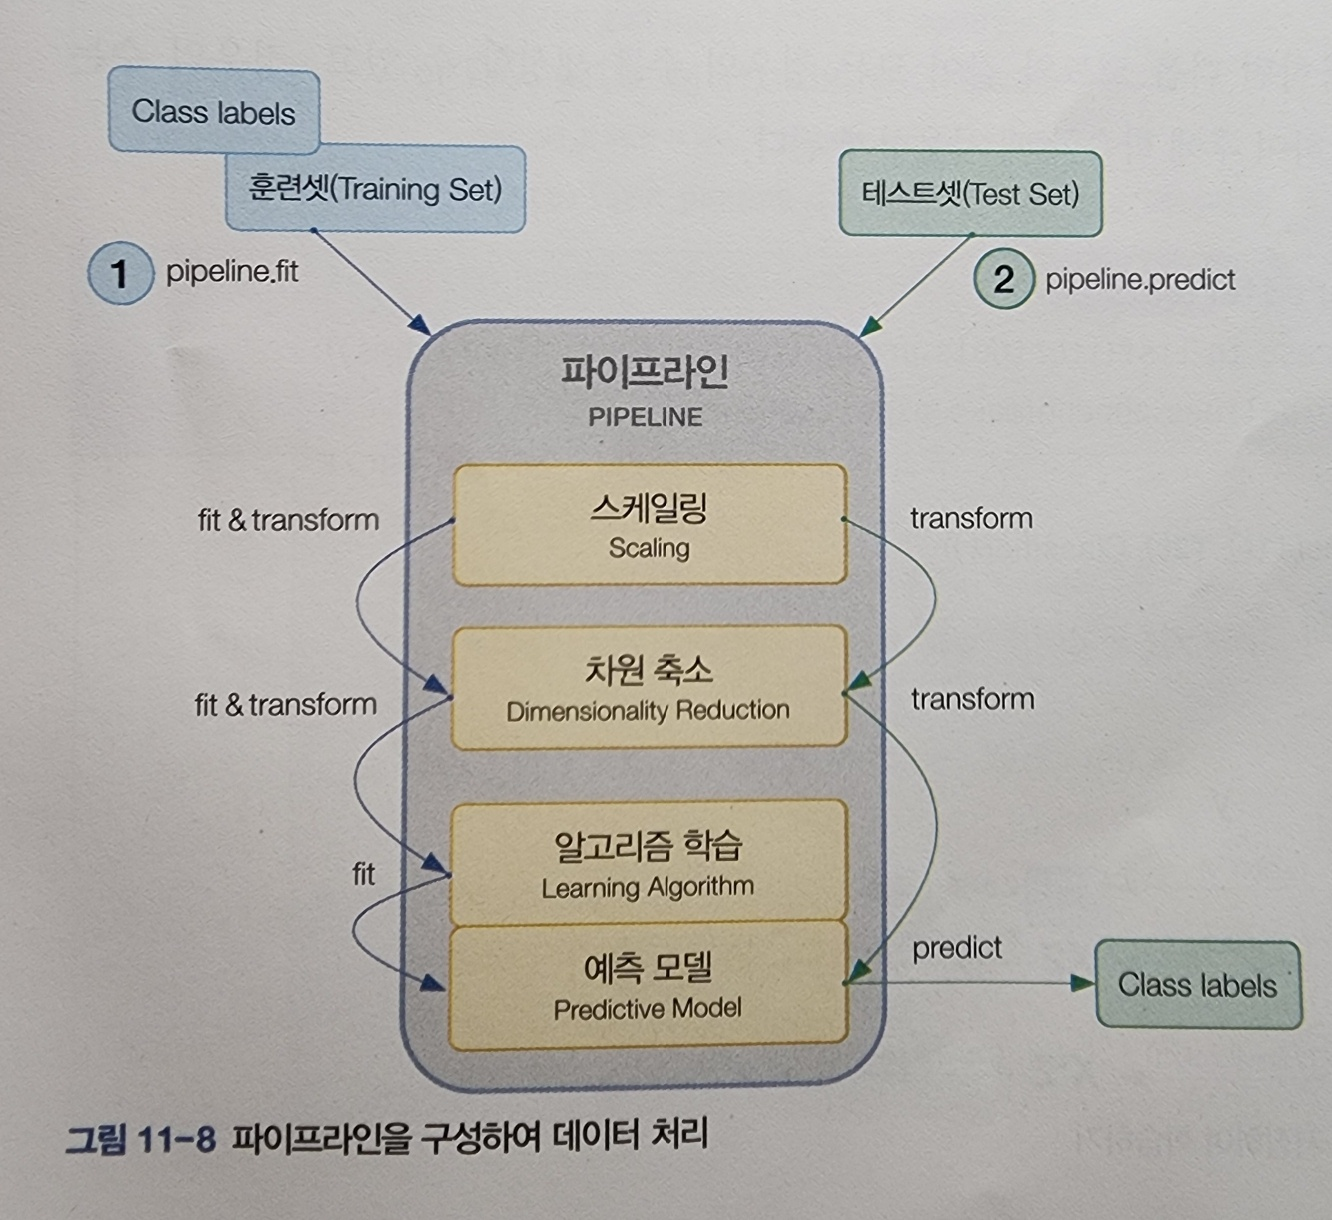

In [64]:
from IPython.display import Image
Image('c:\Machine_Learning (git)\chapter11\Pipeline.jpg')

- 파이프라인을 적용하기 위해 사용할 모든 알고리즘과 사용한 벡터화 종류를 리스트화함

- 다음 코드는 간단히 사용할 클래스들의 리스트를 정리한 코드
    - **vectorizer, algorithms**을 m $\times$ n 이라는 경우의 수로 생성
        - 이렇게 경우의 수가 생성되면 나중에 학습 파이프라인에 넣어서 학습을 수행하게 됨

In [65]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

vectorizer = [CountVectorizer(), TfidfVectorizer(),
              StemmedCountVectorizer(), StemmedTfidfVectorizer()]
# algorithms = [BernoulliNB(), MultinomialNB(), GaussianNB(), LogisticRegression()]
algorithms = [MultinomialNB(), LogisticRegression()]

pipelines = []

In [66]:
# itertools를 사용하면 다음 코드와 같이 모든 경우의 수를 생성할 수 있음
# 경우의 수는 pipelines에 저장하여 후에 학습할 때 사용하게 됨
import itertools
for case in list(itertools.product(vectorizer, algorithms)) :
    pipelines.append(make_pipeline(*case))

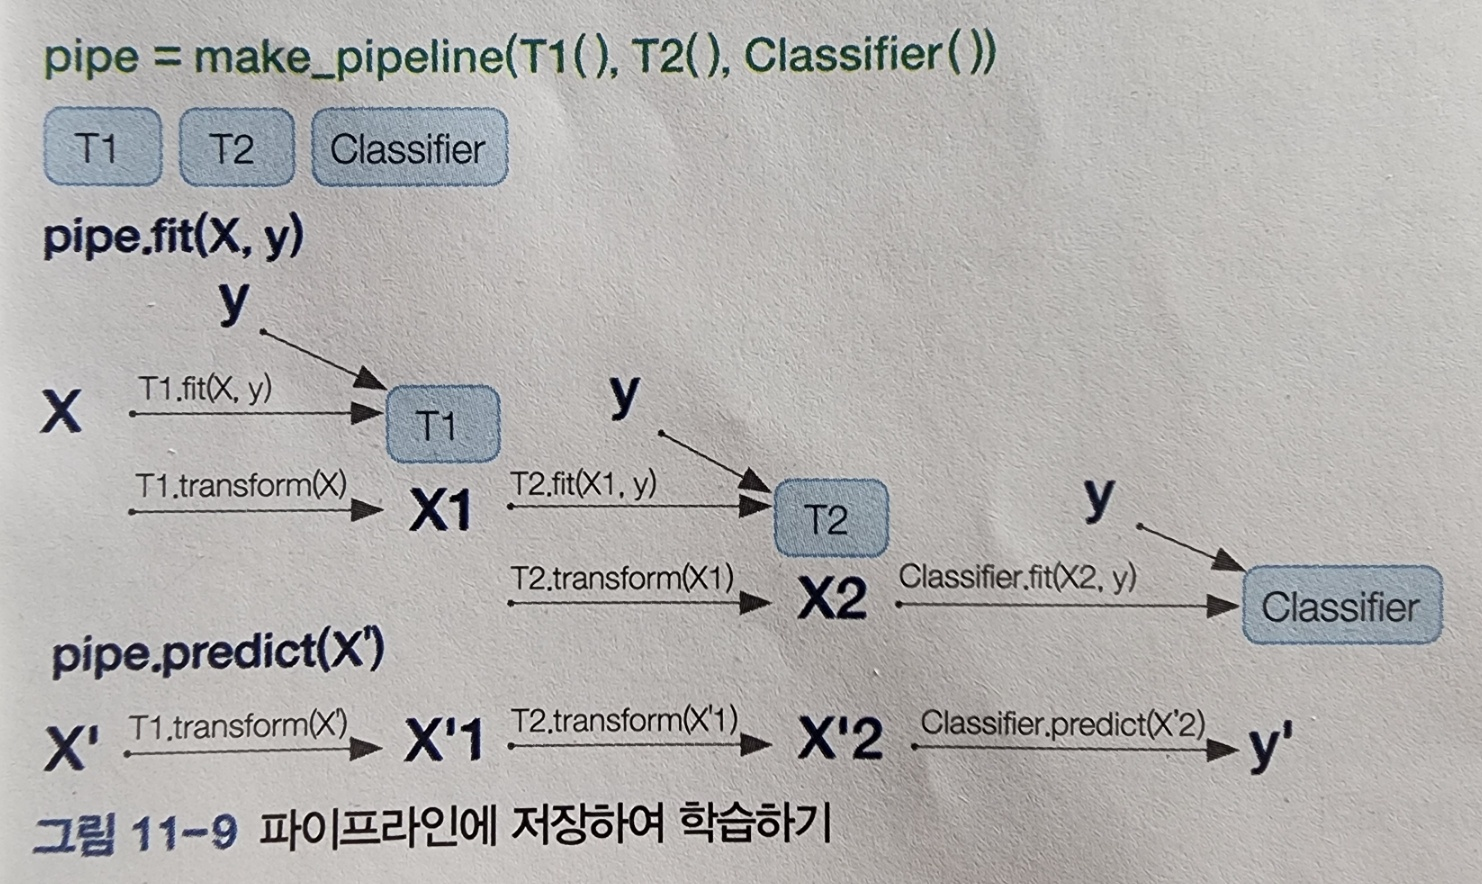

In [67]:
from IPython.display import Image
Image("c:/Machine_Learning (git)/chapter11/Pipeline 2.jpg")

- 다양한 알고리즘의 하이퍼 매개변수를 생성
- 기본적으로 '{클래스의 이름_하이퍼 매개변수의 이름}'으로 구성되어 있음
- 이를 생성하기 위해 다소 복잡하지만 각 모델의 클래스와 벡터화 클래스마다 하이퍼 매개변수를 설정

In [68]:
ngrams_params = [(1, 1), (1, 3)]
stopword_params = ["english"]
lowercase_params = [True, False]
max_df_params = np.linspace(0.4, 0.6, num = 6)
min_df_params = np.linspace(0.0, 0.0, num = 1)

attributes = {"ngram_range" : ngrams_params, "max_df" : max_df_params, "min_df" : min_df_params,
              "lowercase" : lowercase_params, "stop_words" : stopword_params}
vectorizer_names = ["countvectorizer", "tfidfvectorizer",
                    "stemmedcountvectorizer", "stemmedtfidfvectorizer"]
vectorizer_params_dict = {}

for vect_name in vectorizer_names :
    vectorizer_params_dict[vect_name] = {}
    for key, value in attributes.items() :
        param_name = vect_name + "__" + key
        vectorizer_params_dict[vect_name][param_name] = value

In [76]:
algorithm_names = ["multinomialnb", "logisticregression"]

algorithm_params_dict = {}
alpha_params = np.linspace(1.0, 1.0, num = 1)

for i in range(1) :
    algorithm_params_dict[algorithm_names[i]] = {
        algorithm_names[i] + "__alpha" : alpha_params
    }

    c_params = [0.1, 5.0, 7.0, 10.0, 15.0, 20.0, 100.0]

algorithm_params_dict[algorithm_names[1]] = [{
    "logisticregression__multi_class" : ["multinomial"],
    "logisticregression__solver" : ["saga"],
    "logisticregression__penalty" : ["l1"],
    "logisticregression__C" : c_params},
    {"logisticregression__multi_class" : ["ovr"],
    "logisticregression__solver" : ["liblinear"],
    "logisticregression__penalty" : ["l2"],
    "logisticregression__C" : c_params}
]

- 이렇게 각 단계별로 하이퍼 매개변수를 생성하면 이를 파이프라인에 순서대로 입력

- 다음 코드와 같이 **itertools**를 그대로 사용하면서 매개변수들의 리스트를 **pipeline_params**에 저장하여 앞에서 생성한 **pipeline**과 같은 순서가 되도록 하이퍼 매개변수를 만듦

In [77]:
pipeline_params = []

for case in list(itertools.product(vectorizer_names, algorithm_names)) :
    vect_params = vectorizer_params_dict[case[0]].copy()
    algo_params = algorithm_params_dict[case[1]]

    if isinstance(algo_params, dict) :
        vect_params.update(algo_params)
        pipeline_params.append(vect_params)
    else :
        temp = []
        for param in algo_params :
            vect_params.update(param)
            temp.append(vect_params)
        pipeline_params.append(temp)

### 07 - 학습 수행하기

- 이미 파이프라인을 구성하였기에 파이프라인의 순서대로 호출만 할 수 있다면 크게 무리 없이 학습이 가능

- 먼저 X_data, y_data를 다음 코드와 같이 정리

In [79]:
from sklearn.preprocessing import LabelEncoder

X_data = news_df.loc[:, 'News'].tolist()
y_data = news_df['Target'].tolist()
y = LabelEncoder().fit_transform(y_data)

- 다음으로 앞서 생성한 모델의 파이프라인과 하이퍼 매개변수 리스트를 **enumerate**로 호출
    - 그 후 **GridSearchCV**를 사용하여 성능 측정
        - **GridSearchCV** : 하이퍼 매개변수를 사용하여 다양한 경우의 성능을 지정한 **metrics**를 기반으로 측정하고 출력

- 다음 코드에서 정확성에 해당하는 **accuracy**를 기준으로 하이퍼 매개변수들을 사용하여 모델들의 성능이 출력되는 것을 볼 수 있음
    - 다음 코드는 실행하는 데에 상당한 시간이 소요되므로 어떤 내용인지만 파악해도 됨

In [80]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

scoring = ['accuracy']
estimator_results = []

for i, (estimator, params) in enumerate(zip(pipelines, pipeline_params)) :
    n_jobs = -1
    gs_estimator = GridSearchCV(
        refit= "accuracy", estimator= estimator, param_grid= params,
        scoring= scoring, cv= 5, verbose= 1, n_jobs= n_jobs)
    
    print(gs_estimator)

    gs_estimator.fit(X_data, y)
    estimator_results.append(gs_estimator)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'countvectorizer__lowercase': [True, False],
                         'countvectorizer__max_df': array([0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 ]),
                         'countvectorizer__min_df': array([0.]),
                         'countvectorizer__ngram_range': [(1, 1), (1, 3)],
                         'countvectorizer__stop_words': ['english'],
                         'multinomialnb__alpha': array([1.])},
             refit='accuracy', scoring=['accuracy'], verbose=1)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression())]),
           

KeyboardInterrupt: 